In [1]:
%matplotlib inline

## Kaggle Expedia Contest Trial For BOUN SWE 546 Class

The [Expedia Hotel Recommendations](https://www.kaggle.com/c/expedia-hotel-recommendations/data) is a Kaggle Competition that started at 15 April 2016. Expedia wants Kaggle users to contextualize customer data and predict the likelihood a user will stay at 100 different hotel groups.

### Data Information

#### hotel_cluster

- Hotel clusters made of of similar hotels. Similarity not belong to [geographical locations](https://www.kaggle.com/c/expedia-hotel-recommendations/forums/t/20819/clusters-and-countries). Those clusters are based on popularity, star rating, user review rating, price etc. Also hotel clusters may be differs by seasonality.
- Room types and services [did not](https://www.kaggle.com/c/expedia-hotel-recommendations/forums/t/20374/hotel-cluster) taken into account.
- hotel_cluster also can be changes from as they might be clicked/booked from a srch_destination_id differs like "New York and vicinity" or "Statue of Liberty".
- There is total of 100 clusters.

#### is_booking

- Value of this column changes depending on the users action. If the hotel is booked its value is 1 and only clicked its value is 0.

#### srch_destination_id

- srch_destination_id is the id of the location where hotel search made. 

#### orig_destination_distance	

- Physical distance between a hotel and a customer at the time of search. A null means the distance could not be calculated
- Geodesic distance in miles [\*](https://www.kaggle.com/c/expedia-hotel-recommendations/forums/t/20156/welcome/118325#post118325)

#### cnt

- cnt is the # of clicks or booking for a particular hotel in a given user session. In the vast majority of cases there is only one booking for a given hotel per session, hence cnt == 1. In other words you can assume that if is_booking == 1 then cnt == 1. [\*](https://www.kaggle.com/c/expedia-hotel-recommendations/forums/t/20156/welcome/120441#post120441)

#### channel

- Way of the user reached to Expedia web site. 
- Basically, it's an info on how a user got to the expedia web page. It can be something like: "Direct", "SEM" (e.g. via Google paid links), "Meta channel" (e.g. via Tripadvisor), etc.[\*](https://www.kaggle.com/c/expedia-hotel-recommendations/forums/t/20156/welcome/117832)

#### user_location_city

- Location of the user but there are problems with this data there are some cities present in multiple countries.
- Hashing was done by name only and there are cities with the same name in different countries. What it means is that user_location_city should be used only in the context of corresponding user_location_country/region, and user_location_region should be only used in the context of corresponding user_location_country.[\*](https://www.kaggle.com/c/expedia-hotel-recommendations/forums/t/20156/welcome/117832)

#### destinations.csv

- This is a latent description of hotel reviews that are related to a given search destination. These columns correspond to different facets (e.g. beach, ski, etc.) and values are (log) probabilities that a customer would endorse a hotel in the destination for a specific facet.[\*](https://www.kaggle.com/c/expedia-hotel-recommendations/forums/t/20223/what-does-d1-d149-mean-in-destinations/115884)
- Every column in the data is additional descriptors for the specific destination.
- Based on the text data.


### Starting With Loading Required Libraries


In [2]:
import csv
#import time
#from collections import Counter

import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

import seaborn as sns;
from sklearn.neighbors import NearestNeighbors as NN
from sklearn.decomposition import PCA
import random as rnd

### Exploring The Data

In [3]:
destinations = pd.read_csv("destinations.csv")
test = pd.read_csv("test.csv")
train = pd.read_csv("train.csv")

#### Train Data

In [4]:
train.shape

(37670293, 24)

In [5]:
train.head()

,date_time,site_name,posa_continent,user_location_country,user_location_region,user_location_city,orig_destination_distance,user_id,is_mobile,is_package,...,srch_children_cnt,srch_rm_cnt,srch_destination_id,srch_destination_type_id,is_booking,cnt,hotel_continent,hotel_country,hotel_market,hotel_cluster
0,2014-08-11 07:46:59,2,3,66,348,48862,2234.2641,12,0,1,...,0,1,8250,1,0,3,2,50,628,1
1,2014-08-11 08:22:12,2,3,66,348,48862,2234.2641,12,0,1,...,0,1,8250,1,1,1,2,50,628,1
2,2014-08-11 08:24:33,2,3,66,348,48862,2234.2641,12,0,0,...,0,1,8250,1,0,1,2,50,628,1
3,2014-08-09 18:05:16,2,3,66,442,35390,913.1932,93,0,0,...,0,1,14984,1,0,1,2,50,1457,80
4,2014-08-09 18:08:18,2,3,66,442,35390,913.6259,93,0,0,...,0,1,14984,1,0,1,2,50,1457,21


In [6]:
train.describe().T

,count,mean,std,min,25%,50%,75%,max
site_name,37670293,9.795271,11.967544,2.0000,2.000,2.0000,14.0000,53.0000
posa_continent,37670293,2.680473,0.748039,0.0000,3.000,3.0000,3.0000,4.0000
user_location_country,37670293,86.108802,59.243103,0.0000,66.000,66.0000,70.0000,239.0000
user_location_region,37670293,308.406012,208.443750,0.0000,174.000,314.0000,385.0000,1027.0000
user_location_city,37670293,27753.044729,16782.553196,0.0000,13009.000,27655.0000,42413.0000,56508.0000
orig_destination_distance,24145292,1970.090027,2232.442430,0.0056,313.167,1140.4911,2552.5993,12407.9022
user_id,37670293,604451.753178,350617.462041,0.0000,298910.000,603914.0000,910168.0000,1198785.0000
is_mobile,37670293,0.134927,0.341645,0.0000,0.000,0.0000,0.0000,1.0000
is_package,37670293,0.248904,0.432378,0.0000,0.000,0.0000,0.0000,1.0000
channel,37670293,5.870761,3.717095,0.0000,2.000,9.0000,9.0000,10.0000


In [7]:
list(train.columns.values)

['date_time',
 'site_name',
 'posa_continent',
 'user_location_country',
 'user_location_region',
 'user_location_city',
 'orig_destination_distance',
 'user_id',
 'is_mobile',
 'is_package',
 'channel',
 'srch_ci',
 'srch_co',
 'srch_adults_cnt',
 'srch_children_cnt',
 'srch_rm_cnt',
 'srch_destination_id',
 'srch_destination_type_id',
 'is_booking',
 'cnt',
 'hotel_continent',
 'hotel_country',
 'hotel_market',
 'hotel_cluster']

Correlation of columns with hotel_cluster column.

In [8]:
train.corr()["hotel_cluster"]

site_name                   -0.022408
posa_continent               0.014938
user_location_country       -0.010477
user_location_region         0.007453
user_location_city           0.000831
orig_destination_distance    0.007260
user_id                      0.001052
is_mobile                    0.008412
is_package                   0.038733
channel                      0.000707
srch_adults_cnt              0.012309
srch_children_cnt            0.016261
srch_rm_cnt                 -0.005954
srch_destination_id         -0.011712
srch_destination_type_id    -0.032850
is_booking                  -0.021548
cnt                          0.002944
hotel_continent             -0.013963
hotel_country               -0.024289
hotel_market                 0.034205
hotel_cluster                1.000000
Name: hotel_cluster, dtype: float64

#### Test Data

In [9]:
test.shape

(2528243, 22)

In [10]:
test.head()

,id,date_time,site_name,posa_continent,user_location_country,user_location_region,user_location_city,orig_destination_distance,user_id,is_mobile,...,srch_ci,srch_co,srch_adults_cnt,srch_children_cnt,srch_rm_cnt,srch_destination_id,srch_destination_type_id,hotel_continent,hotel_country,hotel_market
0,0,2015-09-03 17:09:54,2,3,66,174,37449,5539.0567,1,1,...,2016-05-19,2016-05-23,2,0,1,12243,6,6,204,27
1,1,2015-09-24 17:38:35,2,3,66,174,37449,5873.2923,1,1,...,2016-05-12,2016-05-15,2,0,1,14474,7,6,204,1540
2,2,2015-06-07 15:53:02,2,3,66,142,17440,3975.9776,20,0,...,2015-07-26,2015-07-27,4,0,1,11353,1,2,50,699
3,3,2015-09-14 14:49:10,2,3,66,258,34156,1508.5975,28,0,...,2015-09-14,2015-09-16,2,0,1,8250,1,2,50,628
4,4,2015-07-17 09:32:04,2,3,66,467,36345,66.7913,50,0,...,2015-07-22,2015-07-23,2,0,1,11812,1,2,50,538


In [11]:
test.describe().T

,count,mean,std,min,25%,50%,75%,max
id,2528243,1264121.000000,729841.032653,0.0000,632060.500000,1264121.00000,1896181.500000,2528242.0000
site_name,2528243,9.709666,12.271834,0.0000,2.000000,2.00000,13.000000,53.0000
posa_continent,2528243,2.697413,0.765129,0.0000,3.000000,3.00000,3.000000,4.0000
user_location_country,2528243,85.516119,56.738799,0.0000,66.000000,66.00000,69.000000,239.0000
user_location_region,2528243,317.034068,208.283389,0.0000,174.000000,318.00000,398.000000,1027.0000
user_location_city,2528243,27862.178063,16687.877646,0.0000,13542.000000,27655.00000,42328.000000,56509.0000
orig_destination_distance,1680782,1686.397964,2197.361433,0.0056,208.069075,727.87645,2222.728625,12206.2318
user_id,2528243,602645.925769,346965.117786,0.0000,302078.500000,604194.00000,903829.500000,1198785.0000
is_mobile,2528243,0.142598,0.349662,0.0000,0.000000,0.00000,0.000000,1.0000
is_package,2528243,0.109325,0.312047,0.0000,0.000000,0.00000,0.000000,1.0000


In [12]:
list(test.columns.values)

['id',
 'date_time',
 'site_name',
 'posa_continent',
 'user_location_country',
 'user_location_region',
 'user_location_city',
 'orig_destination_distance',
 'user_id',
 'is_mobile',
 'is_package',
 'channel',
 'srch_ci',
 'srch_co',
 'srch_adults_cnt',
 'srch_children_cnt',
 'srch_rm_cnt',
 'srch_destination_id',
 'srch_destination_type_id',
 'hotel_continent',
 'hotel_country',
 'hotel_market']

#### Destination Data

In [13]:
destinations.shape

(62106, 150)

It is a huge data with 62106x150 elements. Will need to reduce its size before using it.

In [14]:
destinations.head()

,srch_destination_id,d1,d2,d3,d4,d5,d6,d7,d8,d9,...,d140,d141,d142,d143,d144,d145,d146,d147,d148,d149
0,0,-2.198657,-2.198657,-2.198657,-2.198657,-2.198657,-1.897627,-2.198657,-2.198657,-1.897627,...,-2.198657,-2.198657,-2.198657,-2.198657,-2.198657,-2.198657,-2.198657,-2.198657,-2.198657,-2.198657
1,1,-2.181690,-2.181690,-2.181690,-2.082564,-2.181690,-2.165028,-2.181690,-2.181690,-2.031597,...,-2.165028,-2.181690,-2.165028,-2.181690,-2.181690,-2.165028,-2.181690,-2.181690,-2.181690,-2.181690
2,2,-2.183490,-2.224164,-2.224164,-2.189562,-2.105819,-2.075407,-2.224164,-2.118483,-2.140393,...,-2.224164,-2.224164,-2.196379,-2.224164,-2.192009,-2.224164,-2.224164,-2.224164,-2.224164,-2.057548
3,3,-2.177409,-2.177409,-2.177409,-2.177409,-2.177409,-2.115485,-2.177409,-2.177409,-2.177409,...,-2.161081,-2.177409,-2.177409,-2.177409,-2.177409,-2.177409,-2.177409,-2.177409,-2.177409,-2.177409
4,4,-2.189562,-2.187783,-2.194008,-2.171153,-2.152303,-2.056618,-2.194008,-2.194008,-2.145911,...,-2.187356,-2.194008,-2.191779,-2.194008,-2.194008,-2.185161,-2.194008,-2.194008,-2.194008,-2.188037


In [15]:
destinations.describe().T

,count,mean,std,min,25%,50%,75%,max
srch_destination_id,62106,32359.463884,18711.765765,0.000000,16320.250000,32277.500000,48467.750000,64993.000000
d1,62106,-2.193903,0.038576,-2.597617,-2.209336,-2.185969,-2.175309,-1.596004
d2,62106,-2.202854,0.041065,-2.671613,-2.220192,-2.193247,-2.179261,-1.341325
d3,62106,-2.207391,0.040092,-2.671613,-2.223679,-2.195208,-2.179990,-1.917826
d4,62106,-2.194040,0.041406,-2.671613,-2.211437,-2.188057,-2.176763,-1.814585
d5,62106,-2.161497,0.066197,-2.671613,-2.192158,-2.178255,-2.153317,-1.607558
d6,62106,-2.045110,0.135803,-2.344165,-2.154267,-2.088598,-1.975940,-1.209058
d7,62106,-2.202433,0.038886,-2.671613,-2.218745,-2.192513,-2.178976,-1.474441
d8,62106,-2.203207,0.036578,-2.671613,-2.219086,-2.192915,-2.179164,-1.879678
d9,62106,-2.107808,0.197904,-2.495544,-2.197704,-2.177229,-2.123598,-0.977219


In [16]:
list(destinations.columns.values)

['srch_destination_id',
 'd1',
 'd2',
 'd3',
 'd4',
 'd5',
 'd6',
 'd7',
 'd8',
 'd9',
 'd10',
 'd11',
 'd12',
 'd13',
 'd14',
 'd15',
 'd16',
 'd17',
 'd18',
 'd19',
 'd20',
 'd21',
 'd22',
 'd23',
 'd24',
 'd25',
 'd26',
 'd27',
 'd28',
 'd29',
 'd30',
 'd31',
 'd32',
 'd33',
 'd34',
 'd35',
 'd36',
 'd37',
 'd38',
 'd39',
 'd40',
 'd41',
 'd42',
 'd43',
 'd44',
 'd45',
 'd46',
 'd47',
 'd48',
 'd49',
 'd50',
 'd51',
 'd52',
 'd53',
 'd54',
 'd55',
 'd56',
 'd57',
 'd58',
 'd59',
 'd60',
 'd61',
 'd62',
 'd63',
 'd64',
 'd65',
 'd66',
 'd67',
 'd68',
 'd69',
 'd70',
 'd71',
 'd72',
 'd73',
 'd74',
 'd75',
 'd76',
 'd77',
 'd78',
 'd79',
 'd80',
 'd81',
 'd82',
 'd83',
 'd84',
 'd85',
 'd86',
 'd87',
 'd88',
 'd89',
 'd90',
 'd91',
 'd92',
 'd93',
 'd94',
 'd95',
 'd96',
 'd97',
 'd98',
 'd99',
 'd100',
 'd101',
 'd102',
 'd103',
 'd104',
 'd105',
 'd106',
 'd107',
 'd108',
 'd109',
 'd110',
 'd111',
 'd112',
 'd113',
 'd114',
 'd115',
 'd116',
 'd117',
 'd118',
 'd119',
 'd120',
 'd1

#### Analyzing of Data

In [17]:
train["hotel_cluster"].value_counts()

91    1043720
41     772743
48     754033
64     704734
65     670960
5      620194
98     589178
59     570291
42     551605
21     550092
70     545572
18     545284
83     534132
46     534038
25     530591
62     518809
95     509266
28     507016
68     503797
82     503755
37     496061
50     489892
30     489287
9      488328
58     483253
97     479446
16     477868
72     457463
1      452694
99     444887
       ...   
19     282893
84     278264
66     273505
38     269246
87     260398
23     259233
12     259022
31     257587
67     255946
43     253578
7      252447
54     250745
92     244343
89     243560
45     241408
49     240124
3      225250
80     220218
60     217919
71     216054
93     214293
86     209054
14     192299
75     165226
24     164127
35     139122
53     134812
88     107784
27     105040
74      48355
Name: hotel_cluster, dtype: int64

Hotel Clusters seems not much differs in size. Adding Top 10 to a list to use later.

In [18]:
listofHotelClusters = list(train.hotel_cluster.value_counts().head(10).index)
listofHotelClusters

[91, 41, 48, 64, 65, 5, 98, 59, 42, 21]

### Loading Training File

Preparing Training data file ("*train.csv*") to read by chunks of a million records.

In [19]:
# Note should be read randomly

train = pd.read_csv('train.csv',
                    dtype={'is_booking':int,'srch_destination_id':np.int32, 'hotel_cluster':np.int32},
                    usecols=['srch_destination_id','is_booking','hotel_cluster','user_id','is_mobile'
                             ,'user_location_country','user_location_region','user_location_city'
                             ,'srch_destination_type_id','hotel_continent','hotel_country','hotel_market'
                             ,'orig_destination_distance'],
                    nrows = 10000)
# chunksize=1000000


Let's look at data.

In [20]:
train.head(20)

,user_location_country,user_location_region,user_location_city,orig_destination_distance,user_id,is_mobile,srch_destination_id,srch_destination_type_id,is_booking,hotel_continent,hotel_country,hotel_market,hotel_cluster
0,66,348,48862,2234.2641,12,0,8250,1,0,2,50,628,1
1,66,348,48862,2234.2641,12,0,8250,1,1,2,50,628,1
2,66,348,48862,2234.2641,12,0,8250,1,0,2,50,628,1
3,66,442,35390,913.1932,93,0,14984,1,0,2,50,1457,80
4,66,442,35390,913.6259,93,0,14984,1,0,2,50,1457,21
5,66,442,35390,911.5142,93,0,14984,1,0,2,50,1457,92
6,66,189,10067,NaN,501,0,8267,1,0,2,50,675,41
7,66,189,10067,NaN,501,0,8267,1,0,2,50,675,41
8,66,189,10067,NaN,501,0,8267,1,0,2,50,675,69
9,66,189,10067,NaN,501,0,8267,1,0,2,50,675,70


Aggregating Search Destinations, Hotel Clusters and Users and booking combinations. 

In [21]:
groupped = train.groupby(['srch_destination_id','hotel_cluster','user_id','is_mobile'
                             ,'user_location_country','user_location_region','user_location_city'
                             ,'srch_destination_type_id','hotel_continent','hotel_country','hotel_market'])



In [22]:
grouppedDescribe = groupped['is_booking'].agg([np.sum, np.mean, np.std, len])
print(grouppedDescribe)

                                                                                                                                                                                       sum  \
srch_destination_id hotel_cluster user_id is_mobile user_location_country user_location_region user_location_city srch_destination_type_id hotel_continent hotel_country hotel_market        
11                  94            32708   0         66                    332                  55121              3                        2               50            824             1   
16                  7             43328   0         66                    331                  54953              1                        2               50            419             1   
19                  20            53785   0         1                     173                  23491              1                        5               102           1522            0   
                    30            53785   0       

In [23]:
grouppedDescribe.transpose()

srch_destination_id          11        16    19                      56     \
hotel_cluster                   94        7     20    30    40    61    57   
user_id                      32708     43328 53785 53785 53785 53785 18440   
is_mobile                        0         0     0     0     0     0     1   
user_location_country          66        66    1     1     1     1     68    
user_location_region           332       331   173   173   173   173   335   
user_location_city           55121     54953 23491 23491 23491 23491 3848    
srch_destination_type_id         3         1     1     1     1     1     3   
hotel_continent                  2         2     5     5     5     5     6   
hotel_country                  50        50    102   102   102   102   77    
hotel_market                  824       419   1522  1522  1522  1522  217    
sum                       1.000000  1.000000     0     0     0     0     0   
mean                      0.500000  0.500000     0     0     0     0     0   
std                       0.707107  0.707107   NaN   NaN     0   NaN   NaN   
len                       2.000000  2.000000     1     1     4     1     1   

srch_destination_id      66    68           ...  64591       64627        \
hotel_cluster               50    12    30  ...     62    80    16    18   
user_id                  28433 7899  7899   ...  46929 46929 15286 15286   
is_mobile                    1     0     0  ...      1     1     0     0   
user_location_country      77    205   205  ...    70    70    66    66    
user_location_region       824   354   354  ...    47    47    346   346   
user_location_city       44598 41495 41495  ...  14566 14566 49400 49400   
srch_destination_type_id     1     1     1  ...      1     1     6     6   
hotel_continent              2     3     3  ...      3     3     2     2   
hotel_country              50    1     1    ...    182   182   50    50    
hotel_market              423   142   142   ...   81    81    1632  1632   
sum                          0     0     0  ...      0     0     0     0   
mean                         0     0     0  ...      0     0     0     0   
std                        NaN     0     0  ...    NaN   NaN   NaN   NaN   
len                          1     2     2  ...      1     1     1     1   

srch_destination_id                            65035              
hotel_cluster               34    48    94        10    35    36  
user_id                  15286 38471 38471     2451  2451  2451   
is_mobile                    0     0     0         0     0     0  
user_location_country      66    66    66        3     3     3    
user_location_region       346   174   174       64    64    64   
user_location_city       49400 12089 12089     9448  9448  9448   
srch_destination_type_id     6     6     6         6     6     6  
hotel_continent              2     2     2         6     6     6  
hotel_country              50    50    50        105   105   105  
hotel_market              1632  1632  1632      29    29    29    
sum                       1.00     0     0  1.000000     0     0  
mean                      0.25     0     0  0.142857     0     0  
std                       0.50   NaN   NaN  0.377964   NaN   NaN  
len                       4.00     1     1  7.000000     1     1  

[4 rows x 6014 columns]

Let's visualize data.

#### Top 100 Search Destinations

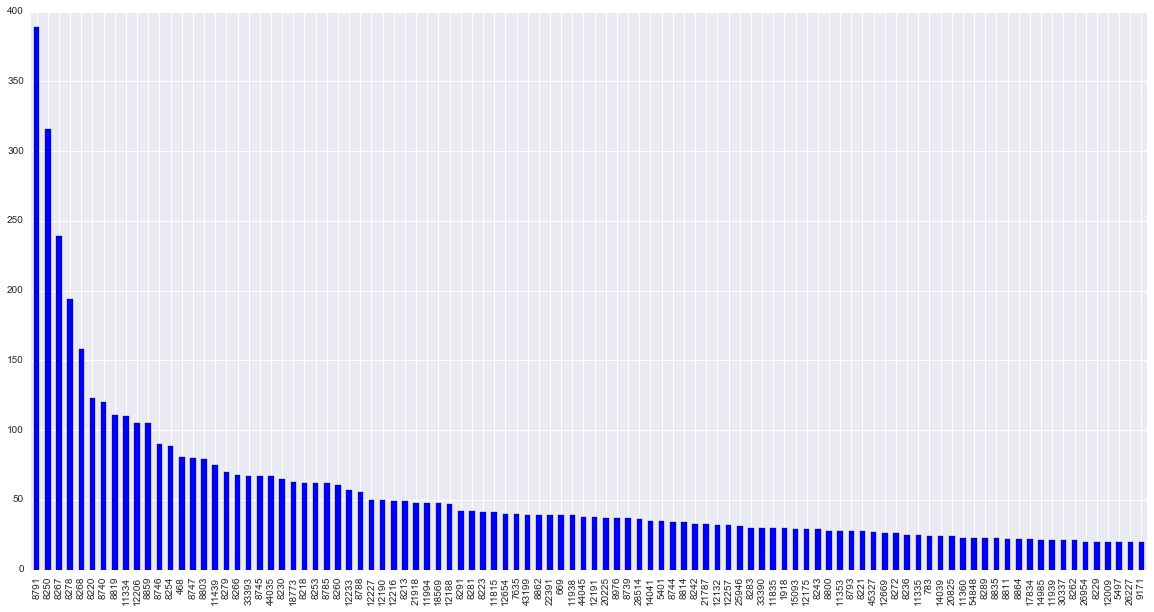

In [24]:
srch_destination_ids = train[['srch_destination_id']].stack().value_counts()
srch_destination_ids = srch_destination_ids[:100]

srch_destination_ids.plot(kind="bar", figsize=(20,10));

#### Top 100 Hotel Clusters

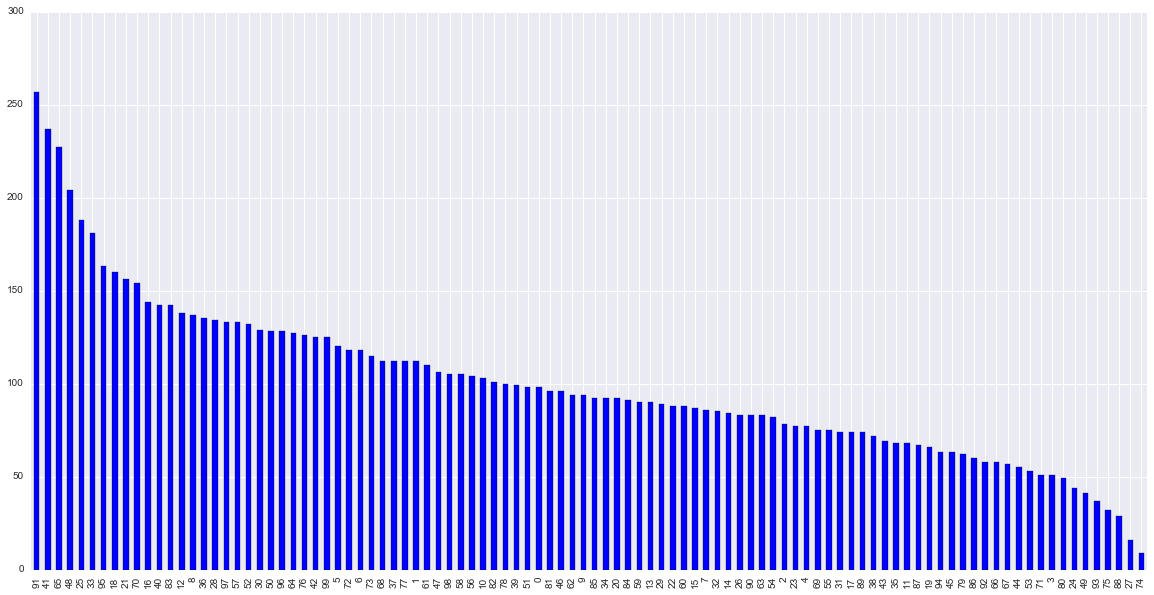

In [25]:
hotel_clusters = train[['hotel_cluster']].stack().value_counts()
hotel_clusters = hotel_clusters[:100]

hotel_clusters.plot(kind="bar", figsize=(20,10));

#### Mobility

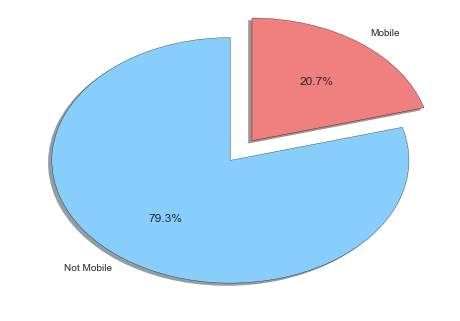

In [26]:
labels = 'Not Mobile', 'Mobile'
colors = ['lightskyblue', 'lightcoral'] 
explode = (0, 0.2)    

is_mobile = train[['is_mobile']].stack().value_counts()
plt.pie(is_mobile, explode=explode,labels=labels, colors=colors, autopct='%1.1f%%', shadow=True, startangle=90);

#### Hotel Continents

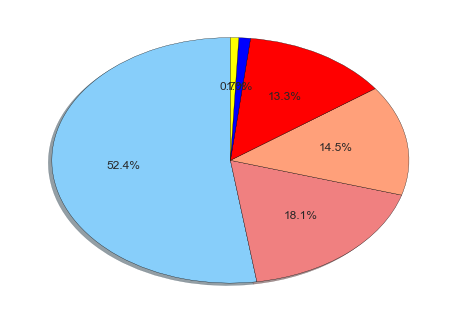

In [27]:
colors = ['lightskyblue', 'lightcoral', 'lightsalmon','red', 'blue', 'yellow'] 
explode = (0.2 , 0.2, 0.2, 0.2, 0.2, 0.2, 0.2)    

hotel_continent = train[['hotel_continent']].stack().value_counts()
plt.pie(hotel_continent, colors=colors, autopct='%1.1f%%', shadow=True, startangle=90);


#### Top 10 User Country

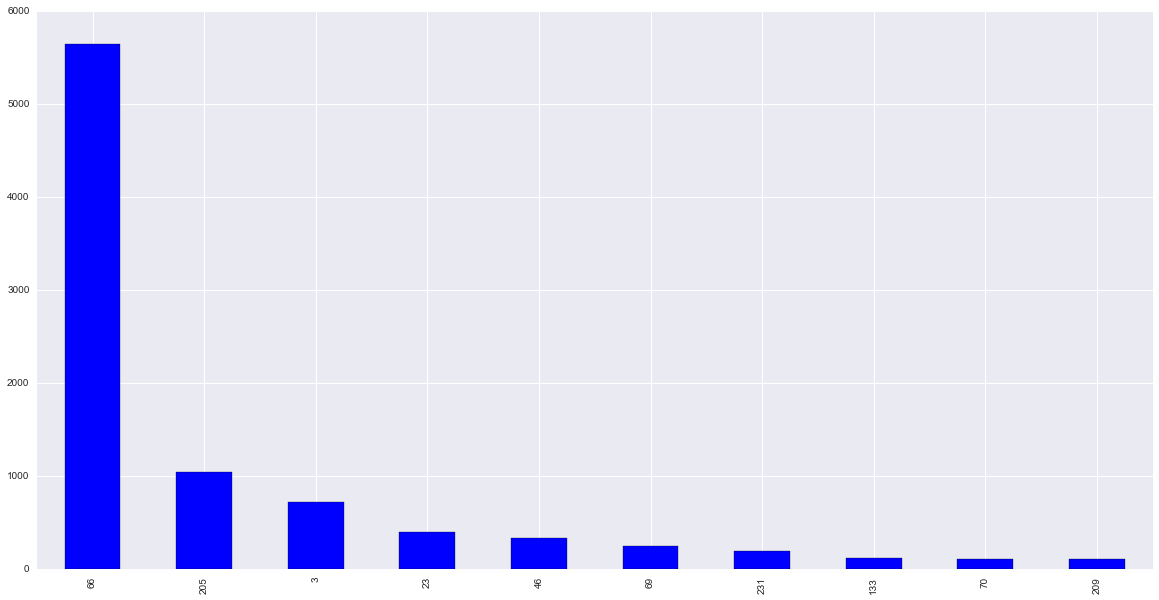

In [28]:
user_location_country = train[['user_location_country']].stack().value_counts()
user_location_country = user_location_country[:10]

user_location_country.plot(kind="bar", figsize=(20,10));

#### Top 10 Hotel Country

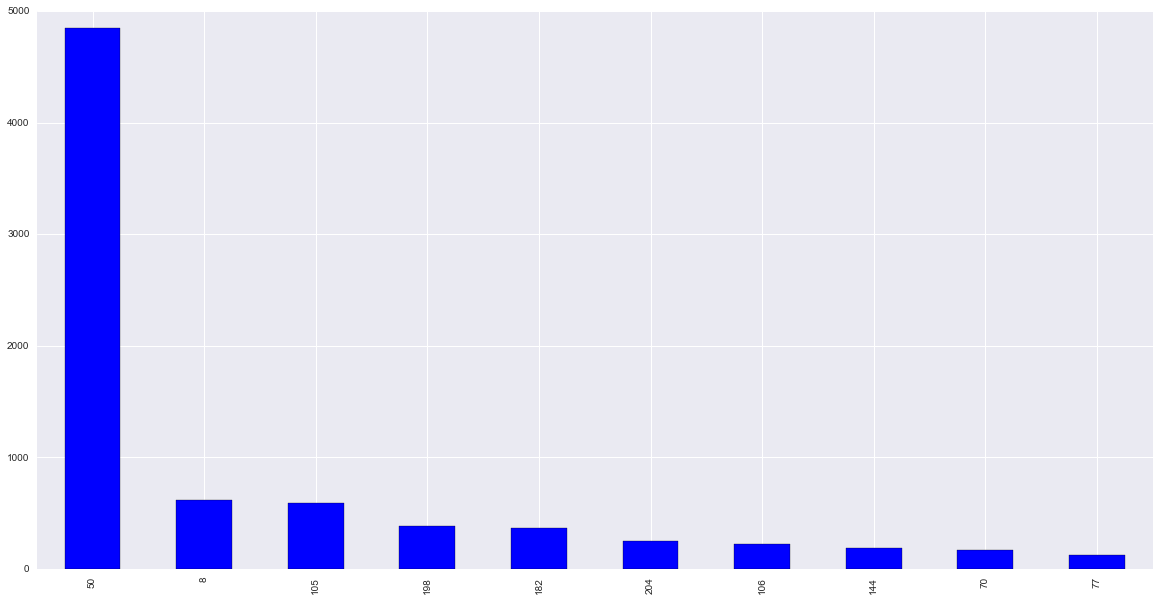

In [29]:
hotel_country = train[['hotel_country']].stack().value_counts()
hotel_country = hotel_country[:10]

hotel_country.plot(kind="bar", figsize=(20,10));

#### Top 20 Hotel Clusters

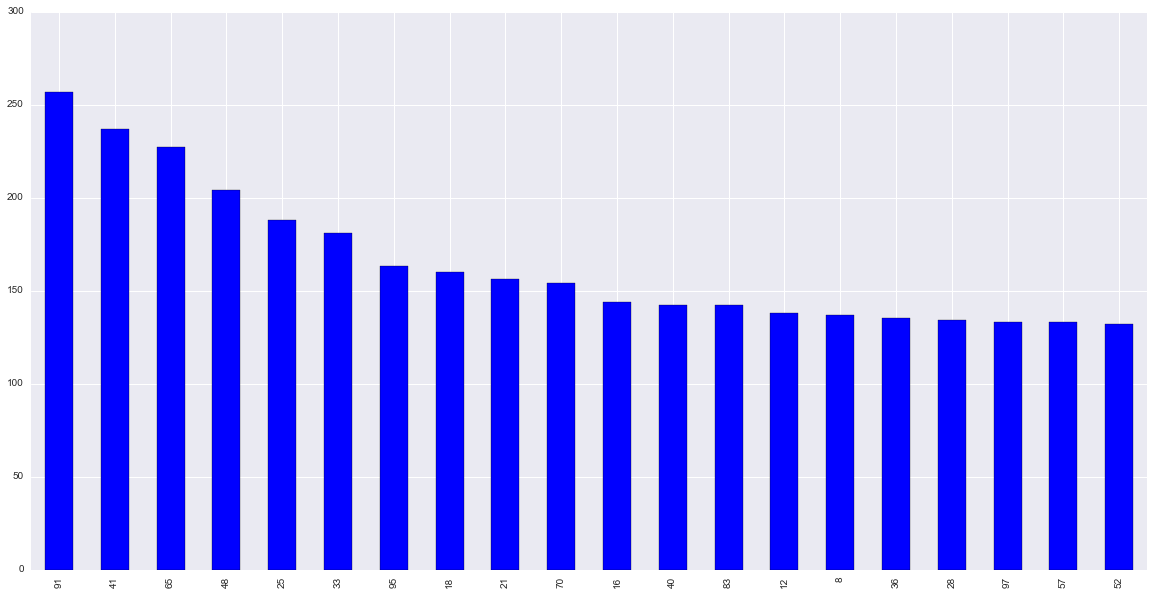

In [30]:
hotel_cluster = train[['hotel_cluster']].stack().value_counts()
hotel_cluster = hotel_cluster[:20]

hotel_cluster.plot(kind="bar", figsize=(20,10));

#### Top 20 User Location Region

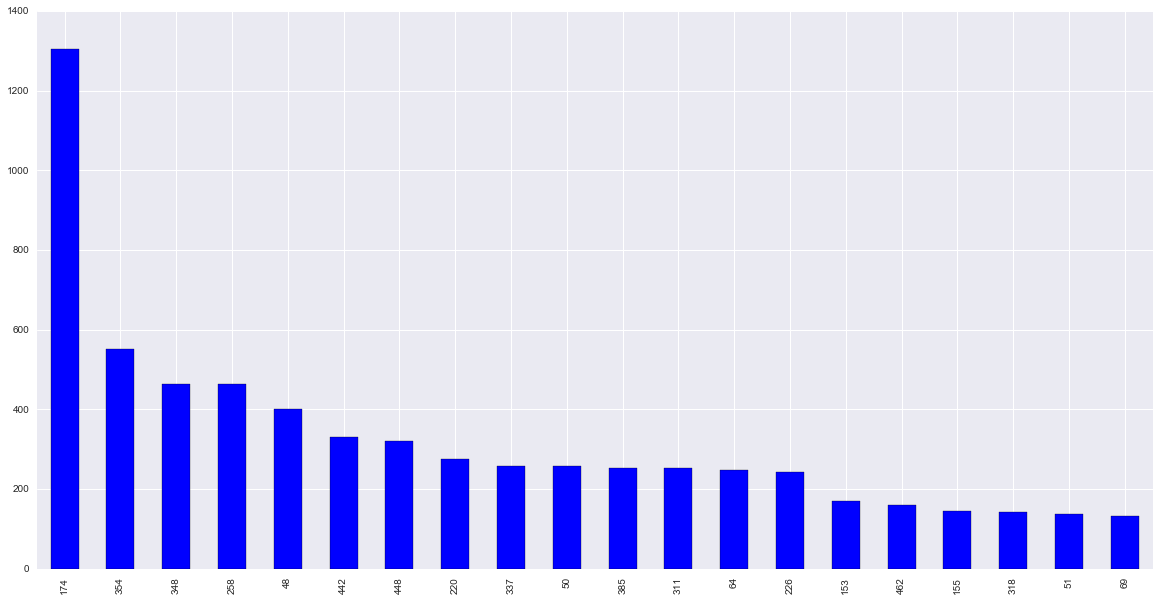

In [31]:
user_location_region = train[['user_location_region']].stack().value_counts()
user_location_region = user_location_region[:20]

user_location_region.plot(kind="bar", figsize=(20,10));

#### Search Destination Types

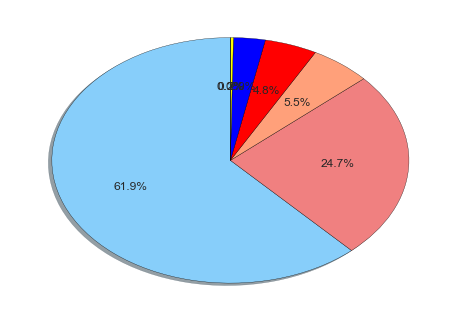

In [32]:
colors = ['lightskyblue', 'lightcoral', 'lightsalmon','red', 'blue', 'yellow'] 
explode = (0.2 , 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2)    

srch_destination_type_id = train[['srch_destination_type_id']].stack().value_counts()
plt.pie(srch_destination_type_id,colors=colors, autopct='%1.1f%%', shadow=True, startangle=90);

#### Top 50 Hotel Market Types

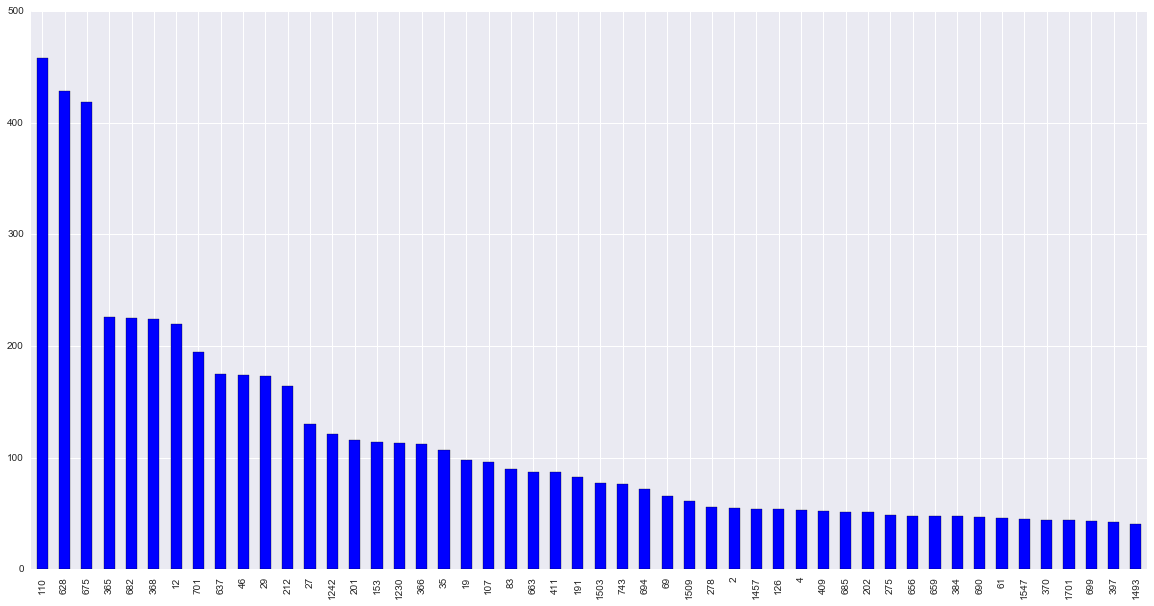

In [33]:
hotel_market = train[['hotel_market']].stack().value_counts()
hotel_market = hotel_market[:50]

hotel_market.plot(kind="bar", figsize=(20,10));


### Aggregation 

#### Aggregation of Mobility and Booking

In [34]:
bymobility = train.groupby(['is_mobile','is_booking'])
bymobility['is_booking'].agg([len])

len
is_mobile is_booking      
0         0           7266
          1            668
1         0           1957
          1            109

#### Aggregation of Hotel Country and Booking

In [35]:
byhotel_country = train.groupby(['hotel_country','is_booking'])
Dbyhotel_country = byhotel_country['is_booking'].agg([len]).head(21)
Dbyhotel_country

len
hotel_country is_booking     
0             0             9
              1             1
1             0            22
              1             4
5             0           107
              1            12
7             0            12
              1             1
8             0           601
              1            16
9             0             1
11            0             2
12            0            10
13            0             1
15            0             7
              1             1
17            0             7
              1             1
21            0             4
22            0           110
              1             6

#### Aggregation of User&Hotel Country and Distance

In [36]:
byHotelUserCountry = (train.groupby(['user_location_country','hotel_country'])
            ['orig_destination_distance']
            .agg(['min','mean','max','count']))
byHotelUserCountry.sort_values(by='count', ascending=False).head(50)

min         mean        max  count
user_location_country hotel_country                                          
66                    50                0.0651   878.458593  4919.3363   3329
                      8                67.9657  1646.567890  2715.7274    528
205                   50               72.7967  1166.993107  4617.5516    306
                      198               0.3525   532.206633  2731.4140    245
46                    50             3552.6385  5206.116346  7369.3665    121
66                    105            4017.9430  5148.988022  5668.2128     98
                      96             1708.6292  2091.154395  3847.8420     95
                      204            3622.6336  4378.498548  5574.6730     89
                      70             3197.4336  3597.703441  5449.1566     85
                      198              64.2148   779.792495  1617.9246     79
205                   106            4703.1869  6486.039235  6653.4168     60
66                    51             1549.1588  1917.512108  3628.3800     59
                      163             903.4882  2450.011319  3606.5251     53
                      146            1701.6404  2070.359761  3330.6340     44
205                   48             6544.5454  6666.788929  6879.1646     42
66                    182            7948.4916  8204.173273  8385.5211     40
                      47             1124.1226  1524.167589  2733.1805     38
205                   122            7296.7497  7578.460154  7663.0520     37
                      8              1477.9649  1665.762365  2123.3098     37
66                    52             2096.8252  2126.359190  2217.8618     30
                      68             3590.5177  3656.538624  3674.1889     29
46                    144               0.9612   163.888243   393.9279     28
66                    106            5171.6429  5541.489074  6781.6023     27
205                   100            5719.5395  5954.335000  6000.3292     25
215                   50              697.1520  1703.206488  2097.4478     25
66                    136             776.0478  1059.096262  3038.8603     24
                      208            4955.9043  5171.302371  6897.9998     24
                      104            7724.3222  7822.216461  8436.3681     23
                      128             194.9472  1365.787038  2888.6667     21
                      46             3863.9927  4417.750111  5853.4842     19
46                    204              68.3193   393.563916   617.5756     19
205                   204            3361.2995  3637.510226  3737.0347     19
66                    118            1769.1515  2046.905558  3992.6183     19
                      93             2796.9435  3063.272928  4171.2476     18
                      22             5046.0753  5352.827043  6021.8135     14
205                   105            4099.8782  4190.790500  4457.3099     14
66                    162            7338.4397  8004.377271  9282.0341     14
205                   92             6736.3683  6754.282707  6803.8929     14
66                    107            4226.2358  4242.743314  4254.9650     14
                      5              8390.0936  8431.419146  8457.2636     13
1                     77              527.8589   533.464238   535.3513     13
66                    140            4886.3161  5570.519731  6046.9571     13
                      186            2001.2775  2183.500300  3920.5500     13
77                    50             9126.0335  9232.688792  9254.8386     12
                      34             1316.8519  1362.046825  1493.6807     12
1                     204             777.8351   788.857127   794.6093     11
182                   50             4252.4571  4254.755573  4257.8595     11
66                    196            4204.0624  5599.126645  6610.1649     11
205                   80             1698.8506  1700.665545  1702.9994     11
46                    82             6482.7758  6502.693460  6669

#### Aggregation of User&Hotel Country and Booking

In [37]:
byHotelUserCountryBooking = train.groupby(['user_location_country','hotel_country','is_booking'])
byHotelUserCountryBooking['is_booking'].agg([len]).sort_values(by='len', ascending=False).head(50)

len
user_location_country hotel_country is_booking      
66                    50            0           3336
                      8             0            547
                      50            1            374
205                   50            0            332
23                    50            0            290
205                   198           0            256
3                     105           0            210
66                    105           0            166
46                    50            0            115
66                    96            0            110
209                   105           0            108
3                     182           0             96
66                    70            0             91
                      198           0             87
                      204           0             87
3                     144           0             79
66                    163           0             73
173                   22            0             70
70                    182           0             67
103                   50            0             61
66                    51            0             60
231                   168           0             57
205                   106           0             56
3                     5             0             54
69                    204           0             54
133                   144           0             52
66                    47            0             50
69                    135           0             48
3                     106           0             48
235                   182           0             47
66                    146           0             46
46                    82            0             45
195                   151           0             44
66                    52            0             43
205                   48            0             42
                      8             0             40
231                   182           0             39
66                    182           0             39
231                   99            0             38
205                   122           0             37
93                    50            0             35
46                    144           0             34
205                   198           1             34
239                   50            0             32
154                   50            0             32
205                   204           0             30
49                    50            0             29
3                     50            0             29
                      77            0             27
66                    106           0             26

#### Aggregation of User, Hotel Cluster and Booking

In [38]:
byUserHotelClusterBooking = train.groupby(['user_id','hotel_cluster','is_booking'])
byUserHotelClusterBooking['is_booking'].agg([sum]).sort_values(by='sum', ascending=False).head(50)

,,,sum
user_id,hotel_cluster,is_booking,
43775,40,1,6
44663,13,1,6
33803,95,1,6
43775,23,1,6
33803,73,1,5
53412,12,1,5
22457,97,1,5
10106,97,1,4
14099,91,1,4


Combination

In [39]:
trainNN = pd.read_csv('train.csv',
                    dtype={'is_booking':int,'srch_destination_id':np.int32, 'hotel_cluster':np.int32},
                    usecols=['user_id','srch_destination_id','hotel_cluster','user_location_country'
                             ,'hotel_country','is_mobile','is_booking'],
                    nrows = 10000)
# chunksize=1000000


byUserID = trainNN.groupby(['user_id'])
byUserID['is_booking'].agg([sum]).sort_values(by='sum', ascending=False).head(50)

,sum
user_id,
33803,33
14099,30
4539,24
43775,23
10106,18
9681,17
32708,17
53412,15
28560,15


#### Trials

Initial Decision Tree, Random Forest and SVC trials.

In [40]:
from sklearn.cross_validation import cross_val_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn import svm

X = trainNN[['user_id','srch_destination_id','user_location_country'
                             ,'hotel_country','is_mobile','is_booking']].values 
y = trainNN['hotel_cluster'].values

clf = DecisionTreeClassifier(random_state=0)
score = cross_val_score(clf, X, y, cv=10)
print(score)

#svc = svm.SVC(kernel  = 'linear')
#print(cross_val_score(svc, X, y, n_jobs=1))

D:\Anaconda3\lib\site-packages\sklearn\cross_validation.py:516: Warning: The least populated class in y has only 9 members, which is too few. The minimum number of labels for any class cannot be less than n_folds=10.
  % (min_labels, self.n_folds)), Warning)


[ 0.09560229  0.11923077  0.11695906  0.13090551  0.13047809  0.10764588
  0.09837728  0.13538462  0.16875     0.10283316]


In [41]:
clf = RandomForestClassifier(n_estimators=10, min_weight_fraction_leaf=0.1)
scores = cross_val_score(clf, X , y, cv=3)
print(scores)

[ 0.03623404  0.05068986  0.04577145]


Let's work on destination data. to get the data smaller i will use PCA decomposition.

In [42]:
pca = PCA(n_components=5)
destPCA = pca.fit_transform(destinations[["d{0}".format(i + 1) for i in range(149)]])
destPCA = pd.DataFrame(destPCA)
destPCA["srch_destination_id"] = destinations["srch_destination_id"]
destPCA

,0,1,2,3,4,srch_destination_id
0,0.044268,-0.169419,-0.032522,-0.014270,0.069690,0
1,0.440761,-0.077405,0.091572,-0.020231,-0.013215,1
2,-0.001033,-0.020677,-0.012108,0.134135,-0.142038,2
3,0.480467,0.040345,0.019320,-0.040100,0.027393,3
4,0.207253,0.042694,0.011744,-0.017520,0.019871,4
5,0.555660,0.032220,0.029087,-0.063347,0.011793,5
6,0.540659,0.035689,0.031810,-0.048726,0.023849,6
7,-0.325618,0.191197,-0.272793,-0.126399,-0.088160,7
8,-0.064419,0.109559,-0.148284,-0.110899,0.019177,8
9,0.525696,0.029234,0.025737,-0.054439,0.002083,9


#### Selecting and Alterating Data

First load the data.

In [43]:
train2 = pd.read_csv('train.csv',
                    dtype={'is_booking':int,'srch_destination_id':np.int32, 'hotel_cluster':np.int32})


Adding year and month to data.

In [44]:
train2["date_time"] = pd.to_datetime(train2["date_time"])
train2["year"] = train2["date_time"].dt.year
train2["month"] = train2["date_time"].dt.month
train2["day"] = train2["date_time"].dt.day

Finding unique user count.

In [45]:
uniquesUsers = train2.user_id.unique()
print(len(uniquesUsers))


1198786


A total of 1198786 unique users present in the data so select some of them for a better processable data. Selecting 10000 of them for creating the algorithm. 

In [46]:
selectedUsers = [uniquesUsers[i] for i in sorted(rnd.sample(range(len(uniquesUsers)), 10000)) ]
filteredData = train2[train2.user_id.isin(selectedUsers)]
len(filteredData)

312559

A total of ~300000 lines of data we have to create our algorithm. 

Creating some a prediction matrix that consists of biggest hotel cluster for each selected user. 

In [47]:
prediction1 = [listofHotelClusters[0:5] for i in range(len(filteredData))]
#prediction1

Calculating correlations between columns of filtered data.

In [48]:
filteredData.corr()["hotel_cluster"]

site_name                   -0.020108
posa_continent               0.009273
user_location_country       -0.010170
user_location_region         0.005924
user_location_city          -0.005558
orig_destination_distance    0.013154
user_id                      0.010849
is_mobile                    0.008236
is_package                   0.036193
channel                      0.000589
srch_adults_cnt              0.016571
srch_children_cnt            0.016686
srch_rm_cnt                 -0.005483
srch_destination_id         -0.009950
srch_destination_type_id    -0.027924
is_booking                  -0.023577
cnt                          0.008745
hotel_continent             -0.011833
hotel_country               -0.020756
hotel_market                 0.035465
hotel_cluster                1.000000
year                        -0.006846
month                       -0.000424
day                          0.000956
Name: hotel_cluster, dtype: float64

As we only use the 1 in 10 of the original data there is only 1 in 1000 diffence in correlations and our sampling seems acceptable.

In [49]:
X = filteredData[['site_name','posa_continent','user_location_country','user_location_region',
                  'user_location_city','user_id','is_mobile','is_package',
                  'channel','srch_adults_cnt','srch_children_cnt','srch_rm_cnt','srch_destination_id',
                  'srch_destination_type_id','is_booking','cnt','hotel_continent','hotel_country','hotel_market','year','month']]
y = filteredData['hotel_cluster']

clf = DecisionTreeClassifier(random_state=0)
score = cross_val_score(clf, X, y, cv=3)
print("Accuracy: %0.2f (+/- %0.2f)" % (score.mean(), score.std() * 2))

Accuracy: 0.08 (+/- 0.00)


In [50]:
clf = RandomForestClassifier(n_estimators=10, min_weight_fraction_leaf=0.1)
score = cross_val_score(clf, X, y, cv=3)
print("Accuracy: %0.2f (+/- %0.2f)" % (score.mean(), score.std() * 2))

Accuracy: 0.06 (+/- 0.01)


In [65]:
from sklearn.tree import DecisionTreeRegressor

clf = DecisionTreeRegressor(max_depth=8)
score = cross_val_score(clf, X, y, cv=3)
print("Accuracy: %0.2f (+/- %0.2f)" % (score.mean(), score.std() * 2))

Accuracy: 0.03 (+/- 0.00)


In [67]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import AdaBoostRegressor

rng = np.random.RandomState(1)

clf = AdaBoostRegressor(DecisionTreeRegressor(max_depth=8),
                          n_estimators=300, random_state=rng)
score = cross_val_score(clf, X, y, cv=3)
print("Accuracy: %0.2f (+/- %0.2f)" % (score.mean(), score.std() * 2))

Accuracy: 0.01 (+/- 0.00)


Some experimental data operations. First calculate some values for each search destination and hotel cluster depending on their bookings. 

In [52]:
def keyName(items):
    return "_".join([str(i) for i in items])


In [53]:
grouppedBysrch_destination_id = filteredData.groupby(['srch_destination_id','hotel_cluster'])
clusterPoints = {}
for name, group in grouppedBysrch_destination_id:
    clicks = len(group.is_booking[group.is_booking == 0])
    bookings = len(group.is_booking[group.is_booking == 1])
    score = bookings + .1 * clicks
    combinedClusterName = keyName(name[:len('srch_destination_id')])
    if combinedClusterName not in clusterPoints:
        clusterPoints[combinedClusterName] = {}
    clusterPoints[combinedClusterName][name[-1]] = score

In [54]:
groupped.head()

,user_location_country,user_location_region,user_location_city,orig_destination_distance,user_id,is_mobile,srch_destination_id,srch_destination_type_id,is_booking,hotel_continent,hotel_country,hotel_market,hotel_cluster
0,66,348,48862,2234.2641,12,0,8250,1,0,2,50,628,1
1,66,348,48862,2234.2641,12,0,8250,1,1,2,50,628,1
2,66,348,48862,2234.2641,12,0,8250,1,0,2,50,628,1
3,66,442,35390,913.1932,93,0,14984,1,0,2,50,1457,80
4,66,442,35390,913.6259,93,0,14984,1,0,2,50,1457,21
5,66,442,35390,911.5142,93,0,14984,1,0,2,50,1457,92
6,66,189,10067,NaN,501,0,8267,1,0,2,50,675,41
7,66,189,10067,NaN,501,0,8267,1,0,2,50,675,41
8,66,189,10067,NaN,501,0,8267,1,0,2,50,675,69
9,66,189,10067,NaN,501,0,8267,1,0,2,50,675,70


In [55]:
import operator

clusterDictionary = {}
for n in clusterPoints:
    tc = clusterPoints[n]
    top = [l[0] for l in sorted(tc.items(), key=operator.itemgetter(1), reverse=True)[:5]]
    clusterDictionary[n] = top

In [56]:
predictions = []
for index, row in filteredData.iterrows():
    key = keyName([row[m] for m in 'srch_destination_id'])
    if key in clusterPoints:
        preds.append(clusterDictionary[key])
    else:
        preds.append([])

KeyError: 's'

In [ ]:
clusterDictionary

### Results So Far

Current format of data did not gives any hint for solutin of the problem. Machine Learning algorithms like DecisionTreeClassifier, RandomForestClassifier, DecisionTreeRegressor and AdaBoostRegressor on non-changed ata did not give good results. (From %8 to %1 train/test in Cross Validtion)

#### So what to do?

- Actually decision tree results are not so bad that much not so well structured data.
- To improve that results we may create additional data like year, month and year to see if there any seasonal relation. 
- For example "cnt" column might be create additional data as it has certain relation with booking event. (it is 1 as an booking done)
- Also destination data can be added to train dataset for more features. We have create a PCA version of this data set (which only consists of 5 columns for each destination) in our work above. 
- Some time series might be created using user sessions and similar users sesions, or click properties of a session and those time series might be used in some time series classifier algorithms like Dynamic Time Warping.
- Same method in Dynamic Time Warping can be used in Times Series created using hotel cluster, user location, destination properties. 
- Mobile users have much less booking rate than non-mobile user and this feaure might increase the successs rate of the algorithm. 
- Some clustering algorithm like K-means can be used for different features and can be used for predictions.
